# IBM Capstone Project
Prepared by Wyatt Walsh

---


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-I:-Data-Collection-and-Preprocessing" data-toc-modified-id="Part-I:-Data-Collection-and-Preprocessing-1">Part I: Data Collection and Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Scrape-Neighborhood-Data-and-Get-Coordinates" data-toc-modified-id="Scrape-Neighborhood-Data-and-Get-Coordinates-1.1">Scrape Neighborhood Data and Get Coordinates</a></span><ul class="toc-item"><li><span><a href="#Process-Dataset" data-toc-modified-id="Process-Dataset-1.1.1">Process Dataset</a></span></li></ul></li><li><span><a href="#Get-Nearby-Venues-of-Neighborhoods-from-Foursquare" data-toc-modified-id="Get-Nearby-Venues-of-Neighborhoods-from-Foursquare-1.2">Get Nearby Venues of Neighborhoods from Foursquare</a></span><ul class="toc-item"><li><span><a href="#Process-Data" data-toc-modified-id="Process-Data-1.2.1">Process Data</a></span></li></ul></li><li><span><a href="#Get-Additional-Venue-Details-from-Yelp" data-toc-modified-id="Get-Additional-Venue-Details-from-Yelp-1.3">Get Additional Venue Details from Yelp</a></span><ul class="toc-item"><li><span><a href="#Process-Data" data-toc-modified-id="Process-Data-1.3.1">Process Data</a></span></li></ul></li></ul></li><li><span><a href="#Part-II:-Exploratory-Data-Analysis" data-toc-modified-id="Part-II:-Exploratory-Data-Analysis-2">Part II: Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Visualize-Variable-Distributions" data-toc-modified-id="Visualize-Variable-Distributions-2.1">Visualize Variable Distributions</a></span></li><li><span><a href="#Find-Top-Categories" data-toc-modified-id="Find-Top-Categories-2.2">Find Top Categories</a></span></li><li><span><a href="#Generate-Map" data-toc-modified-id="Generate-Map-2.3">Generate Map</a></span></li></ul></li><li><span><a href="#Part-III:-Prediction-Modeling" data-toc-modified-id="Part-III:-Prediction-Modeling-3">Part III: Prediction Modeling</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-3.1">Data Preparation</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3.2">Modeling</a></span></li></ul></li><li><span><a href="#Determine-Feature-Importances" data-toc-modified-id="Determine-Feature-Importances-4">Determine Feature Importances</a></span></li></ul></div>

In [2]:
from geopy.geocoders import Nominatim
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import folium
import random
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import time
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, HuberRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error,\
                            r2_score, max_error, make_scorer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import os
import json
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

%matplotlib inline
sns.set_style("whitegrid")

## Part I: Data Collection and Preprocessing

### Scrape Neighborhood Data and Get Coordinates
A list of neighborhoods in Los Angeles is scraped from *Wikipedia*. Furthermore, corresponding coordinates (latitudes and longitudes) are queried. Finally, a Pandas dataframe of the resultant data is created.

In [21]:
path_neighborhoods_raw = 'data/raw/neighborhoods.csv'
if not os.path.exists(path_neighborhoods_raw):
    url_neighborhoods_wiki = "https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_in_Los_Angeles"
    results = requests.get(url_neighborhoods_wiki).text
    soup = BeautifulSoup(results,'lxml')
    neighborhoods = []
    for div in soup.find_all('div', {'class':'div-col'}):
        for item in div.find_all('li'):
            neighborhoods.append(item.text.split('[')[0] + ", Los Angeles, CA")

    latitudes = []
    longitudes = []
    zip_codes = []
    for neighborhood in neighborhoods:
        address = neighborhood
        try:
            geolocator = Nominatim(user_agent="ca_explorer")
            location = geolocator.geocode(address)
            zip_code = location.address.split(", ")[-2]
            zip_codes.append(zip_code)
            latitude = location.latitude
            latitudes.append(latitude)
            longitude = location.longitude
            longitudes.append(longitude)
        except:
            zip_codes.append(np.nan)
            latitudes.append(np.nan)
            longitudes.append(np.nan)
    df_neighborhoods = pd.DataFrame(neighborhoods, columns = ['Neighborhood'])
    df_neighborhoods['Zipcode'] = zip_codes
    df_neighborhoods['Latitude'] = latitudes
    df_neighborhoods['Longitude'] = longitudes
    df_neighborhoods.to_csv(path_neighborhoods_raw)
    print("Data Scraped to /{}".format(path_neighborhoods_raw))
    display(df_neighborhoods.head(), "Shape: {}".format(df_neighborhoods.shape))
else:
    df_neighborhoods = pd.read_csv(path_neighborhoods_raw, index_col=0)
    print("Dataset Loaded as df_neighborhoods")
    display(df_neighborhoods.head(), "Shape: {}".format(df_neighborhoods.shape))

Dataset Loaded as df_neighborhoods


Neighborhood     Zipcode   Latitude   Longitude
0   Angelino Heights, Los Angeles, CA       90026  34.070289 -118.254796
1       Angeles Mesa, Los Angeles, CA       90008  33.991402 -118.319520
2      Angelus Vista, Los Angeles, CA         NaN        NaN         NaN
3             Arleta, Los Angeles, CA  California  34.241327 -118.432205
4  Arlington Heights, Los Angeles, CA  California  34.043494 -118.321374

'Shape: (201, 4)'

#### Process Dataset
- Drop all rows corresponding to a neighborhood for which coordinates could not be found. 
- Remove "Los Angeles" from neighborhood strings

In [22]:
path_neighborhoods_processed = 'data/processed/neighborhoods.csv'
if not os.path.exists(path_neighborhoods_processed):
    # Make copy such that original raw data is not modified
    df = df_neighborhoods.copy()

    # Process by dropping zipcode, removing Los Angeles
    df = df.dropna().drop(['Zipcode'], axis=1).reset_index(drop=True)
    df['Neighborhood'] = df['Neighborhood'].apply(lambda x: x.split(", ")[0])

    # Save processed data to csv
    df.to_csv(path_neighborhoods_processed)
else:
    df = pd.read_csv(path_neighborhoods_processed, index_col=[0,1]).reset_index(drop=True)
    print("Dataset Loaded as df")
display(df.head(), "Shape: {}".format(df.shape))

Dataset Loaded as df


Neighborhood   Latitude   Longitude
0   Angelino Heights  34.070289 -118.254796
1       Angeles Mesa  33.991402 -118.319520
2             Arleta  34.241327 -118.432205
3  Arlington Heights  34.043494 -118.321374
4      Arts District  34.041239 -118.234450

'Shape: (167, 3)'

### Get Nearby Venues of Neighborhoods from Foursquare

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            "AG5AV1CMAKJ2BJZMQDDUADDHQPQ04DGHVHAOSRYDKR4RFVVM", 
            "1SQ3TMP4DH3FBOBCK3C1NZQRRC0XSEG5V1SJXIR1MRDHZ1NR", 
            '20180605', 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['formattedAddress'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Address',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Distance',
                  'Venue Category']
    
    return(nearby_venues)

path_venues_raw = 'data/raw/venues_fs.csv'
if not os.path.exists(path_venues_raw):
    df_venues = getNearbyVenues(names=df['Neighborhood'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude']
                                )
    df_venues.to_csv(path_venues_raw)
    print("Data Scraped to /{}".format(path_venues_raw))
    df_venues_cleaned = df_venues.copy()
else:
    df_venues_cleaned = pd.read_csv(path_venues_raw, index_col=[0]).reset_index(drop=True)
    print("Dataset Loaded as df_venues_cleaned")
display(df_venues_cleaned.head(), "Shape: {}".format(df_venues_cleaned.shape))

Dataset Loaded as df_venues_cleaned


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Angelino Heights              34.070289             -118.254796   
1  Angelino Heights              34.070289             -118.254796   
2  Angelino Heights              34.070289             -118.254796   
3  Angelino Heights              34.070289             -118.254796   
4  Angelino Heights              34.070289             -118.254796   

                                           Venue                  Venue ID  \
0                                Halliwell Manor  4f75a626e5e8f16c87566797   
1                                       Guisados  50e4af3de4b067b02e8b8842   
2                               Eightfold Coffee  560da0fe498e6ed2d672b8ce   
3  Michael Jackson's "Thriller" House (and Tree)  4d9e3a0491cb236a18166397   
4                                          Ototo  5c24e96775dcb7002cf25653   

                                       Venue Address  Venue Latitude  \
0  ['1329 Carroll Ave', 'Los Angeles, CA 90026', ...       34.069329   
1  ['1261 W Sunset Blvd', 'Los Angeles, CA 90026'...       34.070262   
2  ['1294 W Sunset Blvd', 'Los Angeles, CA 90026'...       34.071245   
3  ['1345 Carroll Ave', 'Los Angeles, CA 90026', ...       34.069557   
4  ['1360 Allison Ave', 'Los Angeles, CA 90026', ...       34.072659   

   Venue Longitude  Venue Distance         Venue Category  
0      -118.254165             121  Performing Arts Venue  
1      -118.250437             401             Taco Place  
2      -118.250698             392            Coffee Shop  
3      -118.254599              83          Historic Site  
4      -118.251740             386               Sake Bar

'Shape: (3981, 10)'

#### Process Data

In [24]:
path_venues_processed = 'data/processed/venues_fs.csv'
if not os.path.exists(path_venues_processed):
    df_venues_cleaned['Venue Address'] = df_venues_cleaned['Venue Address'].apply(lambda x: ' '.join(x))
    vvn = df_venues_cleaned.loc[:, ['Venue', 'Venue ID', 'Neighborhood', 'Venue Distance']]
    grouped = vvn.groupby(['Venue ID', 'Venue'])
    ids = pd.DataFrame(grouped['Venue ID'].unique().index)
    names = pd.DataFrame(grouped['Venue'].apply(list))
    neighborhoods = pd.DataFrame(grouped['Neighborhood'].apply(list)).reset_index()
    distances = pd.DataFrame(grouped['Venue Distance'].apply(list)).reset_index()
    num_neighborhoods = max(neighborhoods['Neighborhood'].apply(len).values)
    def helper(num_neighborhoods, ls):
        if len(ls) < num_neighborhoods + 1:
            return 'none'
        else:
            return ls[num_neighborhoods]

    for i in range(num_neighborhoods):
        neighborhoods['Neighborhood {}'.format(i)] = neighborhoods['Neighborhood'].apply(lambda x: helper(i, x))
        neighborhoods['Distance to Neighborhood {}'.format(i)] = distances['Venue Distance'].apply(lambda x: helper(i, x))

    neighborhoods = neighborhoods.drop(['Neighborhood'], axis=1)
    to_merge = df_venues_cleaned[['Venue', 'Venue ID', 'Venue Address', 'Venue Category', \
                                  'Venue Latitude', 'Venue Longitude']].drop_duplicates()
    df_venues_cleaned = pd.merge(neighborhoods, to_merge, on=['Venue', 'Venue ID'])
    df_venues_cleaned.to_csv(path_venues_processed)
else:
    df_venues_cleaned = pd.read_csv(path_venues_processed, index_col=[0]).reset_index(drop=True)
    print("Dataset Loaded as df_venues_cleaned")
display(df_venues_cleaned.head(), "Shape: {}".format(df_venues_cleaned.shape))

Dataset Loaded as df_venues_cleaned


Venue ID                          Venue   Neighborhood 0  \
0  3fd66200f964a52001ef1ee3                       4100 Bar  Sunset Junction   
1  3fd66200f964a52018f01ee3  Pineapple Hill Saloon & Grill     Sherman Oaks   
2  3fd66200f964a5203eef1ee3                  Burgundy Room        Hollywood   
3  3fd66200f964a52045f01ee3                      Tonga Hut      Valley Glen   
4  3fd66200f964a52046ef1ee3                      El Coyote          Fairfax   

   Distance to Neighborhood 0 Neighborhood 1 Distance to Neighborhood 1  \
0                          75           none                       none   
1                         234           none                       none   
2                         269           none                       none   
3                         460           none                       none   
4                         443           none                       none   

  Neighborhood 2 Distance to Neighborhood 2 Neighborhood 3  \
0           none                       none           none   
1           none                       none           none   
2           none                       none           none   
3           none                       none           none   
4           none                       none           none   

  Distance to Neighborhood 3  ... Neighborhood 6 Distance to Neighborhood 6  \
0                       none  ...           none                       none   
1                       none  ...           none                       none   
2                       none  ...           none                       none   
3                       none  ...           none                       none   
4                       none  ...           none                       none   

  Neighborhood 7 Distance to Neighborhood 7 Neighborhood 8  \
0           none                       none           none   
1           none                       none           none   
2           none                       none           none   
3           none                       none           none   
4           none                       none           none   

  Distance to Neighborhood 8  \
0                       none   
1                       none   
2                       none   
3                       none   
4                       none   

                                       Venue Address      Venue Category  \
0  [ ' 1 0 8 7   M a n z a n i t a   S t   ( a t ...                 Bar   
1  [ ' 4 4 5 4   V a n   N u y s   B l v d   S t ...                 Bar   
2  [ ' 1 6 2 1   1 / 2   N   C a h u e n g a   B ...            Dive Bar   
3  [ ' 1 2 8 0 8   V i c t o r y   B l v d   ( b ...            Tiki Bar   
4  [ ' 7 3 1 2   B e v e r l y   B l v d   ( b t ...  Mexican Restaurant   

  Venue Latitude Venue Longitude  
0      34.092979     -118.281512  
1      34.152477     -118.447335  
2      34.100420     -118.329663  
3      34.186535     -118.412202  
4      34.076004     -118.349338  

[5 rows x 24 columns]

'Shape: (3289, 24)'

### Get Additional Venue Details from Yelp

In [25]:
def getVenuesDetails(names, latitudes, longitudes, addresses):
    
    venues_list=[]
    i = 0
    for name, lat, lng, address in zip(names, latitudes, longitudes, addresses):
#         print(name)
        # create the API request URL
        url = 'https://api.yelp.com/v3/businesses/search?&limit={}&latitude={}&longitude={}&term={}'.format(
           5, lat, lng, name)
            
        # make the GET request
        headers = {'Authorization': 'Bearer %s' % "_1cumpkHGIJ44tEwhIHXz83FEokVhW7QvW9X5LLCX3qVaawTzTq4pOMQvANep5flAr7XSCUbig8jaO4C8jAnWwxyinluZBUAUu_5rl7B07_7l73rHy4StbS8wQkcYHYx"}
        results = requests.get(url, headers = headers).json()
        time.sleep(3)
        try:
            if results['total'] != 0:
                for biz in results['businesses']:
                    if biz['name'].lower() == name.lower():
                        try:
                            venues_list.append([(
                            name, lat, lng, address, 
                            biz["id"],
                            biz["review_count"],
                            biz["rating"],
                            biz["price"],
                            biz["categories"])])
                            continue
                        except:
                            continue
                    else:
                        continue


            else:
                continue
        except:
            continue 
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Address', 
                  'Venue ID',
                  'Venue Review Count', 
                  'Venue Rating', 
                  'Venue Price',
                  'Venue Category']
    
    return(nearby_venues)
path_yelp_raw = 'data/raw/yelp.csv'
if not os.path.exists(path_venues_raw):
    df_venues_yelp = getVenuesDetails(names=df_venues_cleaned['Venue'],
                                    latitudes=df_venues_cleaned['Venue Latitude'],
                                   longitudes=df_venues_cleaned['Venue Longitude'],
                                   addresses=df_venues_cleaned['Venue Address']
                                  )
    df_venues_yelp.to_csv(path_yelp_raw)
    print("Data Scraped to /{}".format(path_venues_raw))
    df_venues_yelp_cleaned = df_venues_yelp.copy()
else: 
    df_venues_yelp_cleaned = pd.read_csv(path_yelp_raw, index_col=[0]).reset_index(drop=True)
    print("Dataset Loaded as df_venues_yelp_cleaned")
display(df_venues_yelp_cleaned.head(), "Shape: {}".format(df_venues_cleaned.shape))

Dataset Loaded as df_venues_yelp_cleaned


Venue  Venue Latitude  Venue Longitude  \
0             Guisados       34.070262      -118.250437   
1             Guisados       34.070262      -118.250437   
2     Eightfold Coffee       34.071245      -118.250698   
3                Ototo       34.072659      -118.251740   
4  Subliminal Projects       34.072290      -118.250737   

                                       Venue Address                Venue ID  \
0  1261 W Sunset Blvd Los Angeles, CA 90026 Unite...  BDRVlHnK4l0T0ANb7M-Eqg   
1  1261 W Sunset Blvd Los Angeles, CA 90026 Unite...  qpcH_Fub586U2kw_pQJS3w   
2  1294 W Sunset Blvd Los Angeles, CA 90026 Unite...  I90wd2SGfFc6vmja57qpxA   
3  1360 Allison Ave Los Angeles, CA 90026 United ...  gAMhVggfelvAxE40Bg-ywQ   
4  1331 W Sunset Blvd (at Elysian Park Ave) Los A...  DtuHQpPhePSZ-KxEYJ6z8w   

   Venue Review Count  Venue Rating Venue Price  \
0                2153           4.5           $   
1                2492           4.5           $   
2                 247           4.0          $$   
3                  63           4.0          $$   
4                  11           4.5           $   

                                      Venue Category  
0         [{'alias': 'mexican', 'title': 'Mexican'}]  
1  [{'alias': 'mexican', 'title': 'Mexican'}, {'a...  
2     [{'alias': 'coffee', 'title': 'Coffee & Tea'}]  
3  [{'alias': 'bars', 'title': 'Bars'}, {'alias':...  
4  [{'alias': 'galleries', 'title': 'Art Gallerie...

'Shape: (3289, 24)'

#### Process Data

In [26]:
path_data_processed = 'data/processed/data.csv'
if not os.path.exists(path_data_processed):
    
    num_cats = max(df_venues_yelp_cleaned['Venue Category'].apply(len).values)

    def helper_2(num, ls):
        print(type(ls))
        if len(ls) < num + 1:
            return 'none'
        else:
            print(num)
            print(ls)
            return ls[num]['alias']

    for cat in range(num_cats):
        display(df_venues_yelp_cleaned)
        df_venues_yelp_cleaned['Venue Category {}'.format(cat)] = \
        df_venues_yelp_cleaned['Venue Category'].apply(lambda x: helper_2(cat, x))
    df_venues_yelp_cleaned = df_venues_yelp_cleaned.drop(['Venue Category', 'Venue Address'], axis=1).drop_duplicates(keep=False)
    grouped_yelp = df_venues_yelp_cleaned.groupby('Venue')
    venues_yelp = grouped_yelp['Venue'].unique()
    total_reviews_yelp = pd.DataFrame(grouped_yelp['Venue Review Count'].sum()).reset_index()

    def helper_3(grouped):
        num_reviews = np.array(grouped['Venue Review Count'])
        ratings = np.array(grouped['Venue Rating'])
        return np.dot(num_reviews, ratings)/grouped['Venue Review Count'].sum()

    weighted_ratings = pd.DataFrame(grouped_yelp.apply(lambda x: helper_3(x)),columns=['Venue Weighted Rating']).reset_index()
    grouped_df = grouped_yelp[['Venue Latitude', 'Venue Longitude', "Venue Price"]].first().reset_index()
    merged_df = pd.merge(weighted_ratings, grouped_df, on='Venue')

    for col in df_venues_yelp_cleaned.columns[7:].values:
        merged_df = pd.merge(merged_df, \
                             pd.DataFrame(grouped_yelp[col].first()).reset_index(), \
                             on='Venue')
    merged_df = pd.merge(merged_df, total_reviews_yelp, on='Venue')
    merged_df = pd.merge(merged_df, df_venues_cleaned, on='Venue')
    data = ['Venue Weighted Rating', 'Venue Review Count',  'Venue Price','Venue Category',
            'Venue Category 0', 'Venue Category 1', 'Venue Category 2', 'Venue Category 3',
           'Neighborhood 0','Distance to Neighborhood 0', 'Neighborhood 1',
           'Neighborhood 2',
           'Neighborhood 3',
           'Neighborhood 4',
           'Neighborhood 5',
           'Neighborhood 6',
           'Neighborhood 7',
           'Neighborhood 8']
    data = merged_df[data]
    data.to_csv(path_data_processed)
else: 
    data = pd.read_csv(path_data_processed, index_col=[0]).reset_index(drop=True)
#     dummies = pd.get_dummies(data=data.iloc[:, 2:].drop(['Distance to Neighborhood 0'], axis=1), drop_first=True)
#     non_dummies = data.loc[:, ['Venue Weighted Rating', 'Venue Review Count', "Distance to Neighborhood 0"]]
#     data = pd.concat([non_dummies, dummies], axis=1)
#     print("Dataset Loaded as data")
display(data.head(), "Shape: {}".format(data.shape))

Venue Weighted Rating  Venue Review Count Venue Price Venue Category  \
0               4.318296                1197          $$   Dessert Shop   
1               5.000000                  29           $    Coffee Shop   
2               4.500000                 138          $$     Smoke Shop   
3               4.000000                 528          $$            Bar   
4               3.500000                 381          $$            Bar   

  Venue Category 0  Venue Category 1 Venue Category 2 Venue Category 3  \
0         macarons              none             none             none   
1           coffee  coffeeroasteries         desserts             none   
2        cigarbars              none             none             none   
3             bars              none             none             none   
4     cocktailbars        gastropubs          beerbar             none   

    Neighborhood 0  Distance to Neighborhood 0 Neighborhood 1 Neighborhood 2  \
0     Little Tokyo                         234           none           none   
1     Cypress Park                         488           none           none   
2     Toy District                         496           none           none   
3  Sunset Junction                          75           none           none   
4       Eagle Rock                          71           none           none   

  Neighborhood 3 Neighborhood 4 Neighborhood 5 Neighborhood 6 Neighborhood 7  \
0           none           none           none           none           none   
1           none           none           none           none           none   
2           none           none           none           none           none   
3           none           none           none           none           none   
4           none           none           none           none           none   

  Neighborhood 8  
0           none  
1           none  
2           none  
3           none  
4           none

'Shape: (1501, 18)'

## Part II: Exploratory Data Analysis

### Visualize Variable Distributions

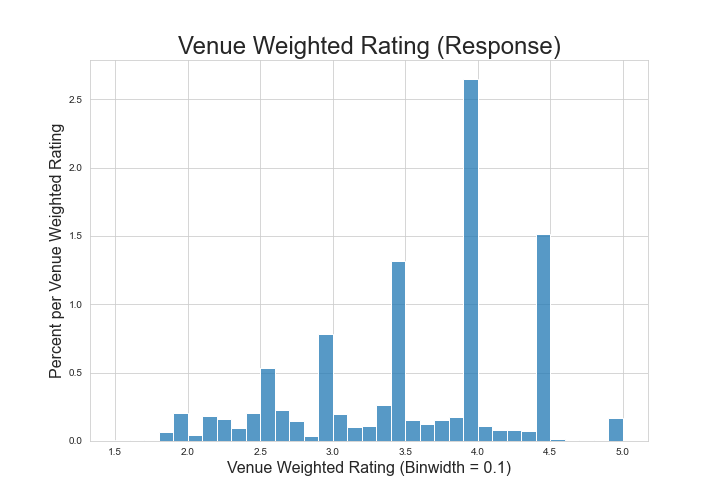

In [8]:
path_hist_response = 'visualizations/histogram_response.png'
if not os.path.exists(path_hist_response):
    fig = plt.figure(figsize=(10,7))
    fig_data = data[['Venue Price','Venue Weighted Rating']]
    hist_response = sns.histplot(fig_data, stat='density', binwidth=0.1, color="#6a9fb5", legend=False);
    plt.xlabel("Venue Weighted Rating (Binwidth = 0.1)", size=16)
    plt.ylabel("Percent per Venue Weighted Rating", size=16)
    plt.title("Venue Weighted Rating (Response)", size=24);
    plt.savefig(path_hist_response)
else:
    display(Image(path_hist_response))

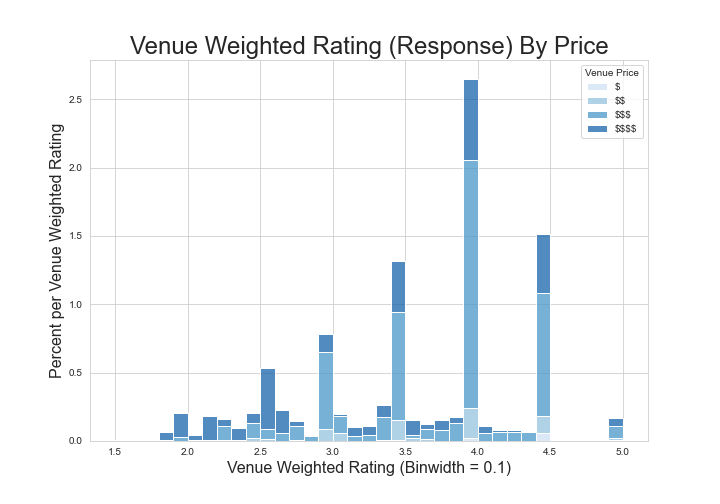

In [9]:
path_hist_response_hue_price = 'visualizations/histogram_response_hue_price.png'
if not os.path.exists(path_hist_response_hue_price):
    fig = plt.figure(figsize=(10,7))
    fig_data = data[['Venue Price','Venue Weighted Rating']]
    to_replace = {'$':"1", '$$':'2', '$$$':"3", '$$$$':'4'}
    fig_data = fig_data.replace(to_replace)
    sns.histplot(data=fig_data, stat='density', binwidth=0.1, x='Venue Weighted Rating', \
             hue='Venue Price', hue_order= ['1', '2','3','4'], multiple='stack', palette=sns.color_palette("Blues_r",4))
    plt.legend(['\$', '\$\$', '\$\$\$', '\$\$\$\$',],loc='upper right', title='Venue Price');
    plt.xlabel("Venue Weighted Rating (Binwidth = 0.1)", size=16)
    plt.ylabel("Percent per Venue Weighted Rating", size=16)
    plt.title("Venue Weighted Rating (Response) By Price", size=24);
    plt.savefig(path_hist_response_hue_price)
else: 
    display(Image(path_hist_response_hue_price))

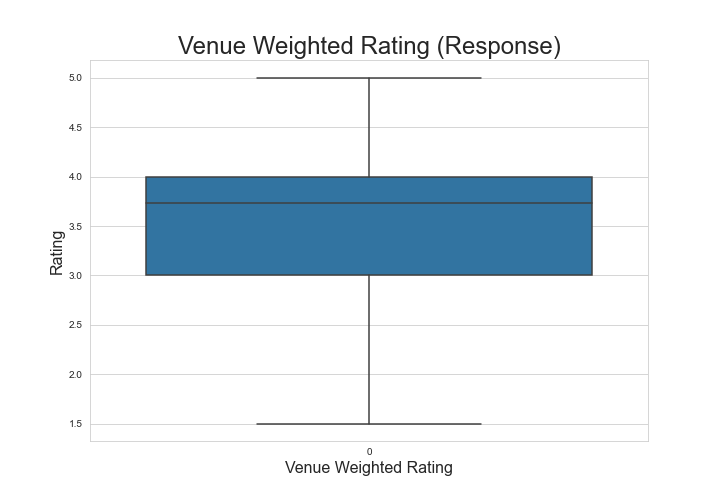

In [10]:
path_box_rating = 'visualizations/box_rating.png'
if not os.path.exists(path_box_rating):
    fig = plt.figure(figsize=(10,7))
    sns.boxplot(data=data['Venue Weighted Rating'])
    plt.xlabel("Venue Weighted Rating", size=16)
    plt.ylabel("Rating", size=16)
    plt.title("Venue Weighted Rating ", size=24);
    plt.savefig(path_box_rating)
else: 
    display(Image(path_box_rating))

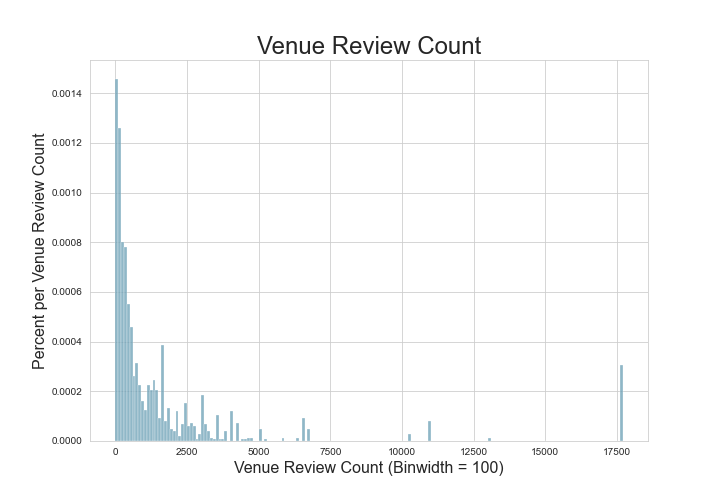

In [11]:
path_hist_review_count = 'visualizations/histogram_review_count.png'
if not os.path.exists(path_hist_review_count):
    fig = plt.figure(figsize=(10,7))
    hist_response = sns.histplot(data['Venue Review Count'], stat='density', binwidth=100,\
                 color = '#6a9fb5');
    plt.xlabel("Venue Review Count (Binwidth = 100)", size=16)
    plt.ylabel("Percent per Venue Review Count", size=16)
    plt.title("Venue Review Count", size=24);
    plt.savefig(path_hist_review_count)
else:
    display(Image(path_hist_review_count))

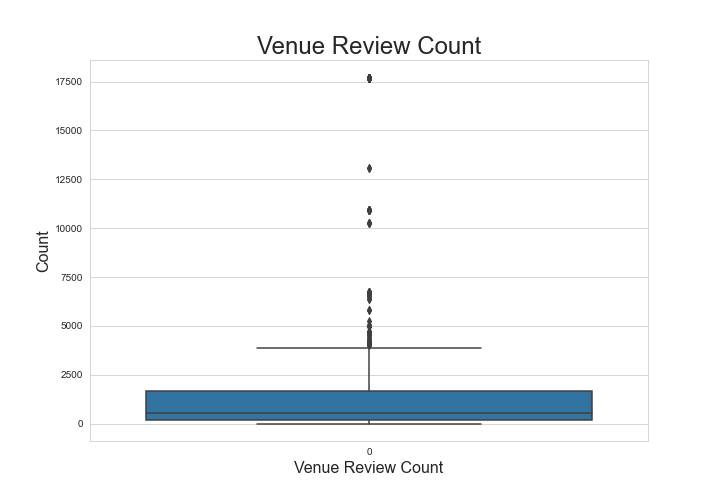

In [12]:
path_box_count = 'visualizations/box_count.png'
if not os.path.exists(path_box_count):
    fig = plt.figure(figsize=(10,7))
    sns.boxplot(data=data['Venue Review Count'])
    plt.xlabel("Venue Review Count", size=16)
    plt.ylabel("Count", size=16)
    plt.title("Venue Review Count", size=24);
    plt.savefig(path_box_count)
else: 
    display(Image(path_box_count))

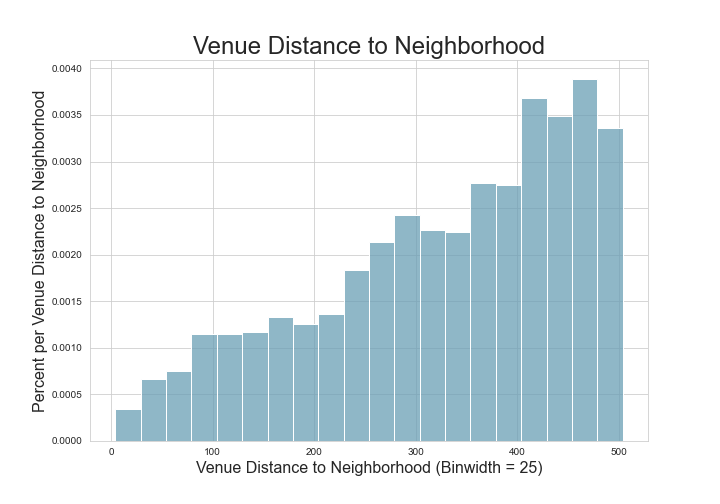

In [13]:
path_hist_review_count = 'visualizations/histogram_distance.png'
if not os.path.exists(path_hist_review_count):
    fig = plt.figure(figsize=(10,7))
    hist_response = sns.histplot(data['Distance to Neighborhood 0'], stat='density', binwidth=25,\
                 color = '#6a9fb5');
    plt.xlabel("Venue Distance to Neighborhood (Binwidth = 25)", size=16)
    plt.ylabel("Percent per Venue Distance to Neighborhood", size=16)
    plt.title("Venue Distance to Neighborhood", size=24);
    plt.savefig(path_hist_review_count)
else:
    display(Image(path_hist_review_count))

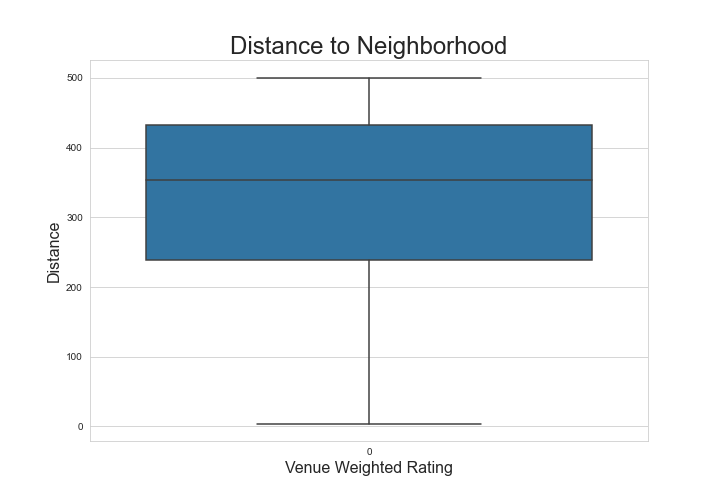

In [14]:
 path_box_distance = 'visualizations/box_distance.png'
if not os.path.exists(path_box_distance):
    fig = plt.figure(figsize=(10,7))
    sns.boxplot(data=data['Distance to Neighborhood 0'])
    plt.xlabel("Distance to Neighborhood 0", size=16)
    plt.ylabel("Distance", size=16)
    plt.title("Distance to Neighborhood", size=24);
    plt.savefig(path_box_distance)
else: 
    display(Image(path_box_distance))

### Find Top Categories

In [15]:
top_categories = data[['Venue Category', 'Venue Weighted Rating', 'Venue Review Count']].groupby('Venue Category')\
.agg({'Venue Weighted Rating':'mean', 'Venue Review Count': 'sum'}).sort_values('Venue Weighted Rating', ascending=False)
top_categories = top_categories.loc[(top_categories['Venue Weighted Rating'] >= top_categories['Venue Weighted Rating'].quantile(0.75))]
top_categories = top_categories.loc[top_categories['Venue Review Count'] > top_categories['Venue Review Count'].quantile(0.75)]
top_categories

Venue Weighted Rating  Venue Review Count
Venue Category                                                          
Taiwanese Restaurant                        4.500000                2348
Creperie                                    4.429841                1018
Yoga Studio                                 4.400188                2236
Food Service                                4.388313                4244
Massage Studio                              4.333333                 768
Arts & Crafts Store                         4.300000                2771
Health & Beauty Service                     4.262955                5314
Wine Bar                                    4.250000                1228
Performing Arts Venue                       4.250000                2613
Vegetarian / Vegan Restaurant               4.176205               22191
Middle Eastern Restaurant                   4.166667               11062
French Restaurant                           4.166667                5009
Brazilian Restaurant                        4.166667                4658

### Generate Map

In [30]:
num_neighborhoods = len(df_venues_cleaned['Neighborhood 0'].unique())
num_venues = len(df_venues_cleaned['Venue Category'].unique())

colors = []

for neighborhood in range((num_neighborhoods + num_venues)):
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    colors = colors + [color]
    
colors_neighborhood = colors[:num_neighborhoods]
print(len(colors_neighborhood), " neighborhood colors")
colors_venues = colors[num_neighborhoods:len(colors)]
print(len(colors_venues), " venue colors")

153  neighborhood colors
341  venue colors


In [33]:
address = "Los Angeles, CA"
geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_la = folium.Map(location=[latitude, longitude], zoom_start=11)

unique_venues = df_venues_cleaned['Venue Category'].unique()
unique_neighborhoods = df_venues_cleaned['Neighborhood 0'].unique()

for lat, lng, venue, venue_category, neighborhood in \
zip(df_venues_cleaned['Venue Latitude'], df_venues_cleaned['Venue Longitude'], df_venues_cleaned['Venue'], \
    df_venues_cleaned['Venue Category'], df_venues_cleaned['Neighborhood 0']):
    index_neighborhood = np.where(unique_neighborhoods == neighborhood)[0][0]
    index_venue = np.where(unique_venues == venue_category)[0][0]
    label = 'Neighborhood: {}, Category: {}, Venue: {}'.format(neighborhood, venue_category, venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors_neighborhood[index_neighborhood],#'blue',
        fill=True,
        fill_color=colors_venues[index_venue],
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
map_la

## Part III: Prediction Modeling

### Data Preparation

In [4]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X = pd.get_dummies(data=X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

pd.options.mode.chained_assignment = None

scaler = MinMaxScaler().fit(X_train.loc[:,['Venue Review Count', 'Distance to Neighborhood 0']])
X_train.loc[:,['Venue Review Count', 'Distance to Neighborhood 0']] = \
pd.DataFrame(scaler.transform(X_train.loc[:,['Venue Review Count', 'Distance to Neighborhood 0']])).values
X_test.loc[:,['Venue Review Count', 'Distance to Neighborhood 0']] = \
pd.DataFrame(scaler.transform(X_test.loc[:,['Venue Review Count', 'Distance to Neighborhood 0']])).values
print(len(X_train), " rows in the training set")
print(len(X_test), " rows in the test set")

1200  rows in the training set
301  rows in the test set


### Modeling

In [5]:
lr = LinearRegression(n_jobs=-1).fit(X_train, y_train)
print("R2: ", lr.score(X_train, y_train))
y_preds_lr = lr.predict(X_test)

results = pd.DataFrame(columns=['model', 'mean_squared_error', 'mean_absolute_error',\
                            'r2_score', 'max_error'])
ls = ['OLS']
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_lr)]
results.loc[0] = ls
results

R2:  0.8601173957719086


model  mean_squared_error  mean_absolute_error      r2_score     max_error
0   OLS        8.202606e+23         2.320748e+11 -1.548810e+24  1.278986e+13

In [6]:
ridge = RidgeCV(alphas=np.arange(0.01, 10, 100), cv=5).fit(X_train, y_train)
print("R2: ", ridge.score(X_train, y_train))
y_preds_ridge = ridge.predict(X_test)
ls = ['Ridge']
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_ridge)]
results.loc[1] = ls
results

R2:  0.8594946460575387


model  mean_squared_error  mean_absolute_error      r2_score     max_error
0    OLS        8.202606e+23         2.320748e+11 -1.548810e+24  1.278986e+13
1  Ridge        6.590374e-01         5.323257e-01 -2.443898e-01  6.398502e+00

In [7]:
lasso = LassoCV(n_alphas=5000, cv=5, n_jobs=-2, random_state=18, max_iter=2500).fit(X_train, y_train)
print("R2: ", lasso.score(X_train, y_train))
y_preds_lasso = lasso.predict(X_test)
ls = ['Lasso']
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_lasso)]
results.loc[2] = ls
results

R2:  0.639069354650747


model  mean_squared_error  mean_absolute_error      r2_score     max_error
0    OLS        8.202606e+23         2.320748e+11 -1.548810e+24  1.278986e+13
1  Ridge        6.590374e-01         5.323257e-01 -2.443898e-01  6.398502e+00
2  Lasso        2.632200e-01         3.786432e-01  5.029899e-01  2.040810e+00

In [8]:
elastic_net = ElasticNetCV(l1_ratio=np.arange(0.01, 1.1, 0.05), n_alphas=500,\
                           cv=5, n_jobs=-2, random_state=18, max_iter=2500).fit(X_train, y_train)
print("R2: ", elastic_net.score(X_train, y_train))
y_preds_elastic_net = elastic_net.predict(X_test)
ls = ['Elastic Net']
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_elastic_net)]
results.loc[3] = ls
results

R2:  0.6932998162500237


model  mean_squared_error  mean_absolute_error      r2_score  \
0          OLS        8.202606e+23         2.320748e+11 -1.548810e+24   
1        Ridge        6.590374e-01         5.323257e-01 -2.443898e-01   
2        Lasso        2.632200e-01         3.786432e-01  5.029899e-01   
3  Elastic Net        2.682267e-01         3.846812e-01  4.935363e-01   

      max_error  
0  1.278986e+13  
1  6.398502e+00  
2  2.040810e+00  
3  2.110204e+00

In [10]:
params = {'epsilon': np.arange(1, 2.1, .1), 'alpha': np.geomspace(0.00001, 1, 50)}

huber = HuberRegressor()
grid_huber = GridSearchCV(huber, params, scoring='neg_mean_squared_error', n_jobs=-2, cv=5).fit(X_train, y_train)
y_preds_huber = grid_huber.predict(X_test)
ls = ['Huber']
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_lasso)]
results.loc[4] = ls
results

/Users/wyattowalsh/miniconda3/envs/coursera/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


model  mean_squared_error  mean_absolute_error      r2_score  \
0          OLS        8.202606e+23         2.320748e+11 -1.548810e+24   
1        Ridge        6.590374e-01         5.323257e-01 -2.443898e-01   
2        Lasso        2.632200e-01         3.786432e-01  5.029899e-01   
3  Elastic Net        2.682267e-01         3.846812e-01  4.935363e-01   
4        Huber        2.632200e-01         3.786432e-01  5.029899e-01   

      max_error  
0  1.278986e+13  
1  6.398502e+00  
2  2.040810e+00  
3  2.110204e+00  
4  2.040810e+00

In [11]:
svr_linear = SVR(kernel='linear').fit(X_train, y_train)
y_preds_svr_linear = svr_linear.predict(X_test)
ls = ['Linear SVR']
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_svr_linear)]
results.loc[5] = ls
results

model  mean_squared_error  mean_absolute_error      r2_score  \
0          OLS        8.202606e+23         2.320748e+11 -1.548810e+24   
1        Ridge        6.590374e-01         5.323257e-01 -2.443898e-01   
2        Lasso        2.632200e-01         3.786432e-01  5.029899e-01   
3  Elastic Net        2.682267e-01         3.846812e-01  4.935363e-01   
4        Huber        2.632200e-01         3.786432e-01  5.029899e-01   
5   Linear SVR        3.197918e-01         3.902497e-01  3.961714e-01   

      max_error  
0  1.278986e+13  
1  6.398502e+00  
2  2.040810e+00  
3  2.110204e+00  
4  2.040810e+00  
5  2.270790e+00

In [12]:
params = {'degree': np.arange(2, 11)}

svr_poly = SVR(kernel='poly')
grid_svr = GridSearchCV(svr_poly, params, scoring='neg_mean_squared_error', n_jobs=-2, cv=5).fit(X_train, y_train)
y_preds_svr_poly = grid_svr.predict(X_test)
ls = ['Poly SVR (Degree {})'.format(grid_svr.best_params_['degree'])]
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_lasso)]
results.loc[6] = ls
results

model  mean_squared_error  mean_absolute_error      r2_score  \
0                  OLS        8.202606e+23         2.320748e+11 -1.548810e+24   
1                Ridge        6.590374e-01         5.323257e-01 -2.443898e-01   
2                Lasso        2.632200e-01         3.786432e-01  5.029899e-01   
3          Elastic Net        2.682267e-01         3.846812e-01  4.935363e-01   
4                Huber        2.632200e-01         3.786432e-01  5.029899e-01   
5           Linear SVR        3.197918e-01         3.902497e-01  3.961714e-01   
6  Poly SVR (Degree 4)        2.632200e-01         3.786432e-01  5.029899e-01   

      max_error  
0  1.278986e+13  
1  6.398502e+00  
2  2.040810e+00  
3  2.110204e+00  
4  2.040810e+00  
5  2.270790e+00  
6  2.040810e+00

In [13]:
params = {'n_neighbors': np.arange(1, 100, 2)}

knn = KNeighborsRegressor(n_jobs=-1)
grid_knn = GridSearchCV(knn, params, scoring='neg_mean_squared_error', n_jobs=-2, cv=5).fit(X_train, y_train)
y_preds_knn = grid_knn.predict(X_test)
ls = ['K-Nearest Neighbors (K = {})'.format(grid_knn.best_params_['n_neighbors'])]
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_lasso)]
results.loc[7] = ls
results

model  mean_squared_error  mean_absolute_error  \
0                          OLS        8.202606e+23         2.320748e+11   
1                        Ridge        6.590374e-01         5.323257e-01   
2                        Lasso        2.632200e-01         3.786432e-01   
3                  Elastic Net        2.682267e-01         3.846812e-01   
4                        Huber        2.632200e-01         3.786432e-01   
5                   Linear SVR        3.197918e-01         3.902497e-01   
6          Poly SVR (Degree 4)        2.632200e-01         3.786432e-01   
7  K-Nearest Neighbors (K = 5)        2.632200e-01         3.786432e-01   

       r2_score     max_error  
0 -1.548810e+24  1.278986e+13  
1 -2.443898e-01  6.398502e+00  
2  5.029899e-01  2.040810e+00  
3  4.935363e-01  2.110204e+00  
4  5.029899e-01  2.040810e+00  
5  3.961714e-01  2.270790e+00  
6  5.029899e-01  2.040810e+00  
7  5.029899e-01  2.040810e+00

In [14]:
# params = {'n_neighbors': np.arange(1, 100, 2)}

rf = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)
# grid_knn = GridSearchCV(knn, params, scoring='neg_mean_squared_error', n_jobs=-2, cv=5).fit(X_train, y_train)
y_preds_rf = rf.predict(X_test)
ls = ['Random Forest']
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_rf)]
results.loc[8] = ls
results

model  mean_squared_error  mean_absolute_error  \
0                          OLS        8.202606e+23         2.320748e+11   
1                        Ridge        6.590374e-01         5.323257e-01   
2                        Lasso        2.632200e-01         3.786432e-01   
3                  Elastic Net        2.682267e-01         3.846812e-01   
4                        Huber        2.632200e-01         3.786432e-01   
5                   Linear SVR        3.197918e-01         3.902497e-01   
6          Poly SVR (Degree 4)        2.632200e-01         3.786432e-01   
7  K-Nearest Neighbors (K = 5)        2.632200e-01         3.786432e-01   
8                Random Forest        2.339943e-01         3.105420e-01   

       r2_score     max_error  
0 -1.548810e+24  1.278986e+13  
1 -2.443898e-01  6.398502e+00  
2  5.029899e-01  2.040810e+00  
3  4.935363e-01  2.110204e+00  
4  5.029899e-01  2.040810e+00  
5  3.961714e-01  2.270790e+00  
6  5.029899e-01  2.040810e+00  
7  5.029899e-01  2.040810e+00  
8  5.581735e-01  2.370570e+00

In [15]:
# params = {'n_neighbors': np.arange(1, 100, 2)}

ab = AdaBoostRegressor().fit(X_train, y_train)
# grid_knn = GridSearchCV(knn, params, scoring='neg_mean_squared_error', n_jobs=-2, cv=5).fit(X_train, y_train)
y_preds_ab = ab.predict(X_test)
ls = ['Adaboost']
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_ab)]
results.loc[9] = ls
results

model  mean_squared_error  mean_absolute_error  \
0                          OLS        8.202606e+23         2.320748e+11   
1                        Ridge        6.590374e-01         5.323257e-01   
2                        Lasso        2.632200e-01         3.786432e-01   
3                  Elastic Net        2.682267e-01         3.846812e-01   
4                        Huber        2.632200e-01         3.786432e-01   
5                   Linear SVR        3.197918e-01         3.902497e-01   
6          Poly SVR (Degree 4)        2.632200e-01         3.786432e-01   
7  K-Nearest Neighbors (K = 5)        2.632200e-01         3.786432e-01   
8                Random Forest        2.339943e-01         3.105420e-01   
9                     Adaboost        3.470039e-01         4.901675e-01   

       r2_score     max_error  
0 -1.548810e+24  1.278986e+13  
1 -2.443898e-01  6.398502e+00  
2  5.029899e-01  2.040810e+00  
3  4.935363e-01  2.110204e+00  
4  5.029899e-01  2.040810e+00  
5  3.961714e-01  2.270790e+00  
6  5.029899e-01  2.040810e+00  
7  5.029899e-01  2.040810e+00  
8  5.581735e-01  2.370570e+00  
9  3.447897e-01  1.863255e+00

In [16]:
# params = {'n_neighbors': np.arange(1, 100, 2)}

et = ExtraTreesRegressor().fit(X_train, y_train)
# grid_knn = GridSearchCV(knn, params, scoring='neg_mean_squared_error', n_jobs=-2, cv=5).fit(X_train, y_train)
y_preds_et = et.predict(X_test)
ls = ['Extra Trees']
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_et)]
results.loc[10] = ls
results

model  mean_squared_error  mean_absolute_error  \
0                           OLS        8.202606e+23         2.320748e+11   
1                         Ridge        6.590374e-01         5.323257e-01   
2                         Lasso        2.632200e-01         3.786432e-01   
3                   Elastic Net        2.682267e-01         3.846812e-01   
4                         Huber        2.632200e-01         3.786432e-01   
5                    Linear SVR        3.197918e-01         3.902497e-01   
6           Poly SVR (Degree 4)        2.632200e-01         3.786432e-01   
7   K-Nearest Neighbors (K = 5)        2.632200e-01         3.786432e-01   
8                 Random Forest        2.339943e-01         3.105420e-01   
9                      Adaboost        3.470039e-01         4.901675e-01   
10                  Extra Trees        2.581803e-01         3.085164e-01   

        r2_score     max_error  
0  -1.548810e+24  1.278986e+13  
1  -2.443898e-01  6.398502e+00  
2   5.029899e-01  2.040810e+00  
3   4.935363e-01  2.110204e+00  
4   5.029899e-01  2.040810e+00  
5   3.961714e-01  2.270790e+00  
6   5.029899e-01  2.040810e+00  
7   5.029899e-01  2.040810e+00  
8   5.581735e-01  2.370570e+00  
9   3.447897e-01  1.863255e+00  
10  5.125058e-01  2.665000e+00

In [17]:
# params = {'n_neighbors': np.arange(1, 100, 2)}

gb = GradientBoostingRegressor().fit(X_train, y_train)
# grid_knn = GridSearchCV(knn, params, scoring='neg_mean_squared_error', n_jobs=-2, cv=5).fit(X_train, y_train)
y_preds_gb = gb.predict(X_test)
ls = ['Gradient Boosting']
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_gb)]
results.loc[11] = ls
results

model  mean_squared_error  mean_absolute_error  \
0                           OLS        8.202606e+23         2.320748e+11   
1                         Ridge        6.590374e-01         5.323257e-01   
2                         Lasso        2.632200e-01         3.786432e-01   
3                   Elastic Net        2.682267e-01         3.846812e-01   
4                         Huber        2.632200e-01         3.786432e-01   
5                    Linear SVR        3.197918e-01         3.902497e-01   
6           Poly SVR (Degree 4)        2.632200e-01         3.786432e-01   
7   K-Nearest Neighbors (K = 5)        2.632200e-01         3.786432e-01   
8                 Random Forest        2.339943e-01         3.105420e-01   
9                      Adaboost        3.470039e-01         4.901675e-01   
10                  Extra Trees        2.581803e-01         3.085164e-01   
11            Gradient Boosting        2.724515e-01         4.009010e-01   

        r2_score     max_error  
0  -1.548810e+24  1.278986e+13  
1  -2.443898e-01  6.398502e+00  
2   5.029899e-01  2.040810e+00  
3   4.935363e-01  2.110204e+00  
4   5.029899e-01  2.040810e+00  
5   3.961714e-01  2.270790e+00  
6   5.029899e-01  2.040810e+00  
7   5.029899e-01  2.040810e+00  
8   5.581735e-01  2.370570e+00  
9   3.447897e-01  1.863255e+00  
10  5.125058e-01  2.665000e+00  
11  4.855590e-01  2.006649e+00

In [19]:
# params = {'n_neighbors': np.arange(1, 100, 2)}

mlp = MLPRegressor(hidden_layer_sizes=1000, max_iter=500).fit(X_train, y_train)
# grid_knn = GridSearchCV(knn, params, scoring='neg_mean_squared_error', n_jobs=-2, cv=5).fit(X_train, y_train)
y_preds_mlp = mlp.predict(X_test)
ls = ['MLP']
for metric in [mean_squared_error, mean_absolute_error,\
                            r2_score, max_error]:
    ls = ls + [metric(y_test, y_preds_mlp)]
results.loc[12] = ls
results

model  mean_squared_error  mean_absolute_error  \
0                           OLS        8.202606e+23         2.320748e+11   
1                         Ridge        6.590374e-01         5.323257e-01   
2                         Lasso        2.632200e-01         3.786432e-01   
3                   Elastic Net        2.682267e-01         3.846812e-01   
4                         Huber        2.632200e-01         3.786432e-01   
5                    Linear SVR        3.197918e-01         3.902497e-01   
6           Poly SVR (Degree 4)        2.632200e-01         3.786432e-01   
7   K-Nearest Neighbors (K = 5)        2.632200e-01         3.786432e-01   
8                 Random Forest        2.339943e-01         3.105420e-01   
9                      Adaboost        3.470039e-01         4.901675e-01   
10                  Extra Trees        2.581803e-01         3.085164e-01   
11            Gradient Boosting        2.724515e-01         4.009010e-01   
12                          MLP        3.725084e-01         4.348077e-01   

        r2_score     max_error  
0  -1.548810e+24  1.278986e+13  
1  -2.443898e-01  6.398502e+00  
2   5.029899e-01  2.040810e+00  
3   4.935363e-01  2.110204e+00  
4   5.029899e-01  2.040810e+00  
5   3.961714e-01  2.270790e+00  
6   5.029899e-01  2.040810e+00  
7   5.029899e-01  2.040810e+00  
8   5.581735e-01  2.370570e+00  
9   3.447897e-01  1.863255e+00  
10  5.125058e-01  2.665000e+00  
11  4.855590e-01  2.006649e+00  
12  2.966322e-01  2.228088e+00

## Determine Feature Importances

In [42]:
pd.DataFrame(rf.feature_importances_, index = X_train.columns).sort_values(0, ascending=False).head(25)

0
Venue Review Count                   0.263515
Venue Category_Fast Food Restaurant  0.052256
Distance to Neighborhood 0           0.036229
Venue Price_$$                       0.035055
Venue Category 0_servicestations     0.022454
Venue Category 1_convenience         0.021031
Venue Category_Pharmacy              0.019997
Venue Category_Discount Store        0.019882
Venue Price_$$$                      0.019810
Venue Category 1_hotdogs             0.018675
Venue Category 0_drugstores          0.018003
Venue Category 2_none                0.016268
Venue Category 0_mexican             0.013049
Venue Category 0_hotdogs             0.012651
Venue Category_Pizza Place           0.011760
Venue Category 0_deptstores          0.011750
Venue Category_Grocery Store         0.010687
Neighborhood 0_Panorama City         0.008569
Venue Category 0_pizza               0.007647
Venue Category_Ice Cream Shop        0.006735
Venue Category 1_none                0.006558
Venue Category 0_grocery             0.006101
Neighborhood 0_University Hills      0.005820
Venue Category_Convenience Store     0.005118
Venue Category 1_tradamerican        0.004895